In [ ]:
import math
import gym
from gym import spaces
from gym.utils import seeding
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
gamma = 0.7
alpha = 0.5
r_choose = 0.01

# Q(s) = Q(s) + alpha * (reward + gamma*argmax(Q(s')) - Q(s))
# observation (position, velocity)
# action 0~2 (back, stop, forward)

# state table
state_number = 20
action_number = 3

needRender = False

def observationToState(ob, e):
    position = ob[0]
    velocity = ob[1]
    if velocity >= 0:
        v = 1
    else:
        v = 0
    section = (e.max_position - e.min_position)/state_number
    p = position - e.min_position
    p = int(p/section)
    s = p + v*state_number
    return s


In [252]:
env = gym.make('MountainCar-v0')
env._max_episode_steps = 1000

def RL(rewardMethod):
    states = np.zeros([state_number*2,action_number])
    cur_state = 0
    i_episode = 0

    episode_size = 1000

    timeepisode = list()
    finishsteps = list()
    while(i_episode < episode_size):
        observation = env.reset()
        if needRender:
            env.render()
    
        # init state
        cur_state = observationToState(observation, env.env)
    
        if i_episode % 100 == 0:
            print("start {} episode !".format(i_episode))
    
        for t in range(env._max_episode_steps):
            if needRender:
                env.render()
        
            # choose action & random choose
            tmp = random.random()
            if (tmp >= r_choose):
                action = np.argmax(states[cur_state])
            else:
                action = random.randint(0,2)
        
            # step
            observation, reward, done, info = env.step(action)
            
            R = rewardMethod(observation, reward, done, t+1)
        
            # update state
            tmp_state = observationToState(observation, env.env)
            tmp_action = np.argmax(states[tmp_state])
        
            # update value
            states[cur_state][action] = states[cur_state][action] + alpha*(R + gamma*states[tmp_state][tmp_action] - states[cur_state][action])
            cur_state = tmp_state

            if done:
                timeepisode.append(i_episode)
                finishsteps.append(t+1)
                break
    
        i_episode = i_episode + 1
    print("finish {} episode!".format(episode_size))
    
    return (timeepisode, finishsteps);

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [253]:
def originReward(observation, reward, done, step):
    return reward

def originRewardWithDone(observation, reward, done, step):
    if done and step < env._max_episode_steps:
        return 5
    else:
        return reward
    
def calEngery(ob):
    p = ob[0]
    v = ob[1]
    return (math.sin(3 * p)*.45+.55) + v * v

def customRewardwow(ob):
    #e = calEngery(ob)
    #maxe = calEngery((0.527,0.07))
    #mine = calEngery((-0.527,0))
    #tmp = (maxe + mine)/2
    #e -= tmp
    #e *= 2
    maxr = 1
    minr = -1
    maxp = 0.6
    minp = -1.2
    p = ob[0]
    e = (p - minp)/(maxp-minp)
    e = (e * (maxr - minr)) + minr
    
    #return e*100 + p
    return e
    
    
def customReward(observation, reward, done, step):
    return customRewardwow(observation)

def customRewardWithDone(observation, reward, done, step):
    if done and step < env._max_episode_steps:
        return 5
    else:
        return customRewardwow(observation)
    

In [254]:
print("\norigin reward")
tmp = RL(originReward)
originR = tmp[1]

print("\norigin reward with done")
tmp = RL(originRewardWithDone)
originRD = tmp[1]

print("\ncustom reward")
tmp = RL(customReward)
customR = tmp[1]

print("\ncustom reward with done")
tmp = RL(customRewardWithDone)
customRD = tmp[1]

print("\n\nfinish!~")

origin reward
start 0 episode !
start 100 episode !
start 200 episode !
start 300 episode !
start 400 episode !
start 500 episode !
start 600 episode !
start 700 episode !
start 800 episode !
start 900 episode !
finish 1000 episode!
origin reward with done
start 0 episode !
start 100 episode !
start 200 episode !
start 300 episode !
start 400 episode !
start 500 episode !
start 600 episode !
start 700 episode !
start 800 episode !
start 900 episode !
finish 1000 episode!
custom reward
start 0 episode !
start 100 episode !
start 200 episode !
start 300 episode !
start 400 episode !
start 500 episode !
start 600 episode !
start 700 episode !
start 800 episode !
start 900 episode !
finish 1000 episode!
custom reward with done
start 0 episode !
start 100 episode !
start 200 episode !
start 300 episode !
start 400 episode !
start 500 episode !
start 600 episode !
start 700 episode !
start 800 episode !
start 900 episode !
finish 1000 episode!
finish!~


In [273]:
def doneRatio(data):
    count = 0
    ratio = list()
    for i in range(len(data)):
        if data[i] < env._max_episode_steps:
            count += 1
        ratio.append(count/(i+1))
    
    return ratio

def averageStep(data):
    total = 0
    average = list()
    for i in range(len(data)):
        total += data[i]
        average.append(total/(i+1))
    return average

def minStep(data):
    mins = env._max_episode_steps
    minimum = list()
    for i in range(len(data)):
        if mins > data[i]:
            mins = data[i]
        minimum.append(mins)
    return minimum

plt.rcParams['savefig.dpi'] = 300 #圖片畫素
plt.rcParams['figure.dpi'] = 600 #解析度

def plotLearnCurve(title, labels, datas):
    plt.rcParams['figure.figsize'] = (24.0, 6.0) 
    
    plt.subplot(1,3,1)
    for i in range(len(datas)):
        plt.plot(doneRatio(datas[i]), label=labels[i])
    plt.xlabel("episodes")
    plt.ylabel("done ratio")
    plt.title("done ratio")
    
    plt.subplot(1,3,2)
    for i in range(len(datas)):
        plt.plot(averageStep(datas[i]), label=labels[i])
    plt.xlabel("episodes")
    plt.ylabel("average steps")
    plt.title("average steps")
    
    
    plt.subplot(1,3,3)
    for i in range(len(datas)):
        plt.plot(minStep(datas[i]), label=labels[i])
    plt.xlabel("episodes")
    plt.ylabel("minimum steps")
    plt.title("minimum steps")
    
    plt.legend()
    plt.show()

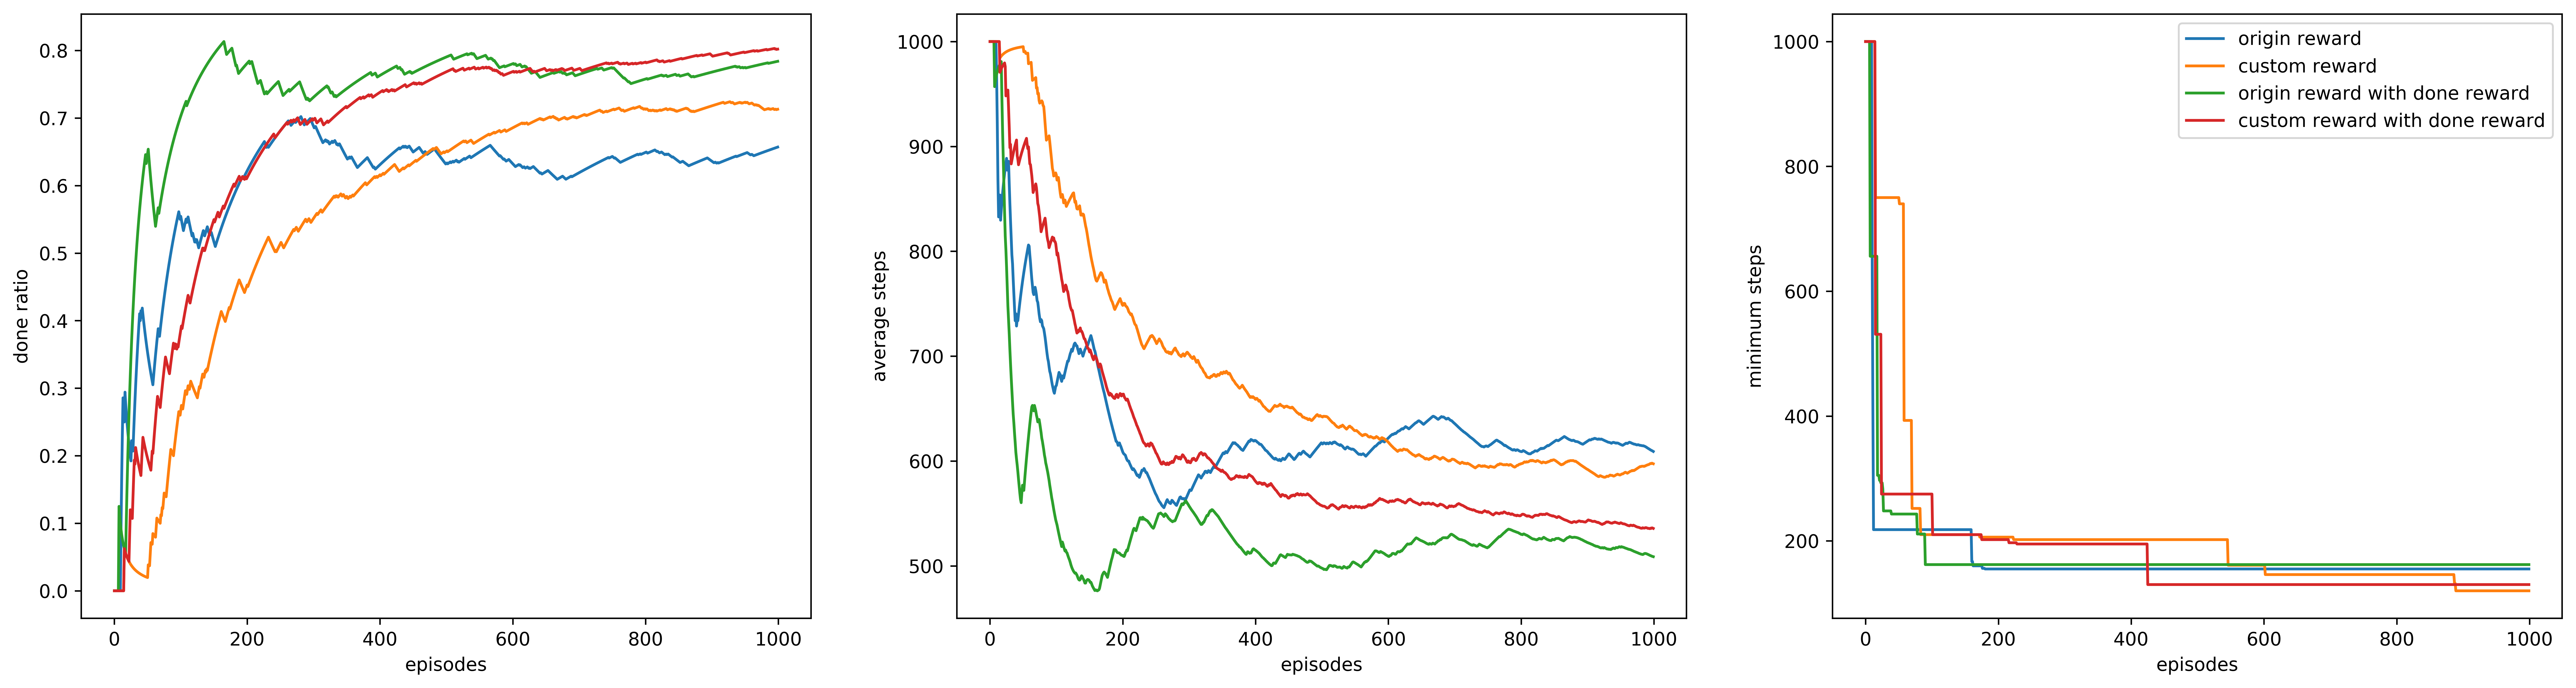

In [257]:
plotLearnCurve("learn curve in diff reward", 
               ["origin reward", "custom reward", "origin reward with done reward", "custom reward with done reward"],
               [originR, customR, originRD, customRD]
              )

In [259]:
alphadatas = list()
alphalabels = list()

gamma = 0.7
r_choose = 0.01

alpha = 0.3

print("\nalpha = {}".format(alpha))
alphalabels.append("alpha {}".format(alpha))
tmp = RL(customRewardWithDone)
alphadatas.append(tmp[1])

alpha = 0.5

print("\nalpha = {}".format(alpha))
alphalabels.append("alpha {}".format(alpha))
tmp = RL(customRewardWithDone)
alphadatas.append(tmp[1])

alpha = 0.7

print("\nalpha = {}".format(alpha))
alphalabels.append("alpha {}".format(alpha))
tmp = RL(customRewardWithDone)
alphadatas.append(tmp[1])

print("\n\nfinish!~")


alpha = 0.3
start 0 episode !
start 100 episode !
start 200 episode !
start 300 episode !
start 400 episode !
start 500 episode !
start 600 episode !
start 700 episode !
start 800 episode !
start 900 episode !
finish 1000 episode!

alpha = 0.5
start 0 episode !
start 100 episode !
start 200 episode !
start 300 episode !
start 400 episode !
start 500 episode !
start 600 episode !
start 700 episode !
start 800 episode !
start 900 episode !
finish 1000 episode!

alpha = 0.7
start 0 episode !
start 100 episode !
start 200 episode !
start 300 episode !
start 400 episode !
start 500 episode !
start 600 episode !
start 700 episode !
start 800 episode !
start 900 episode !
finish 1000 episode!


finish!~


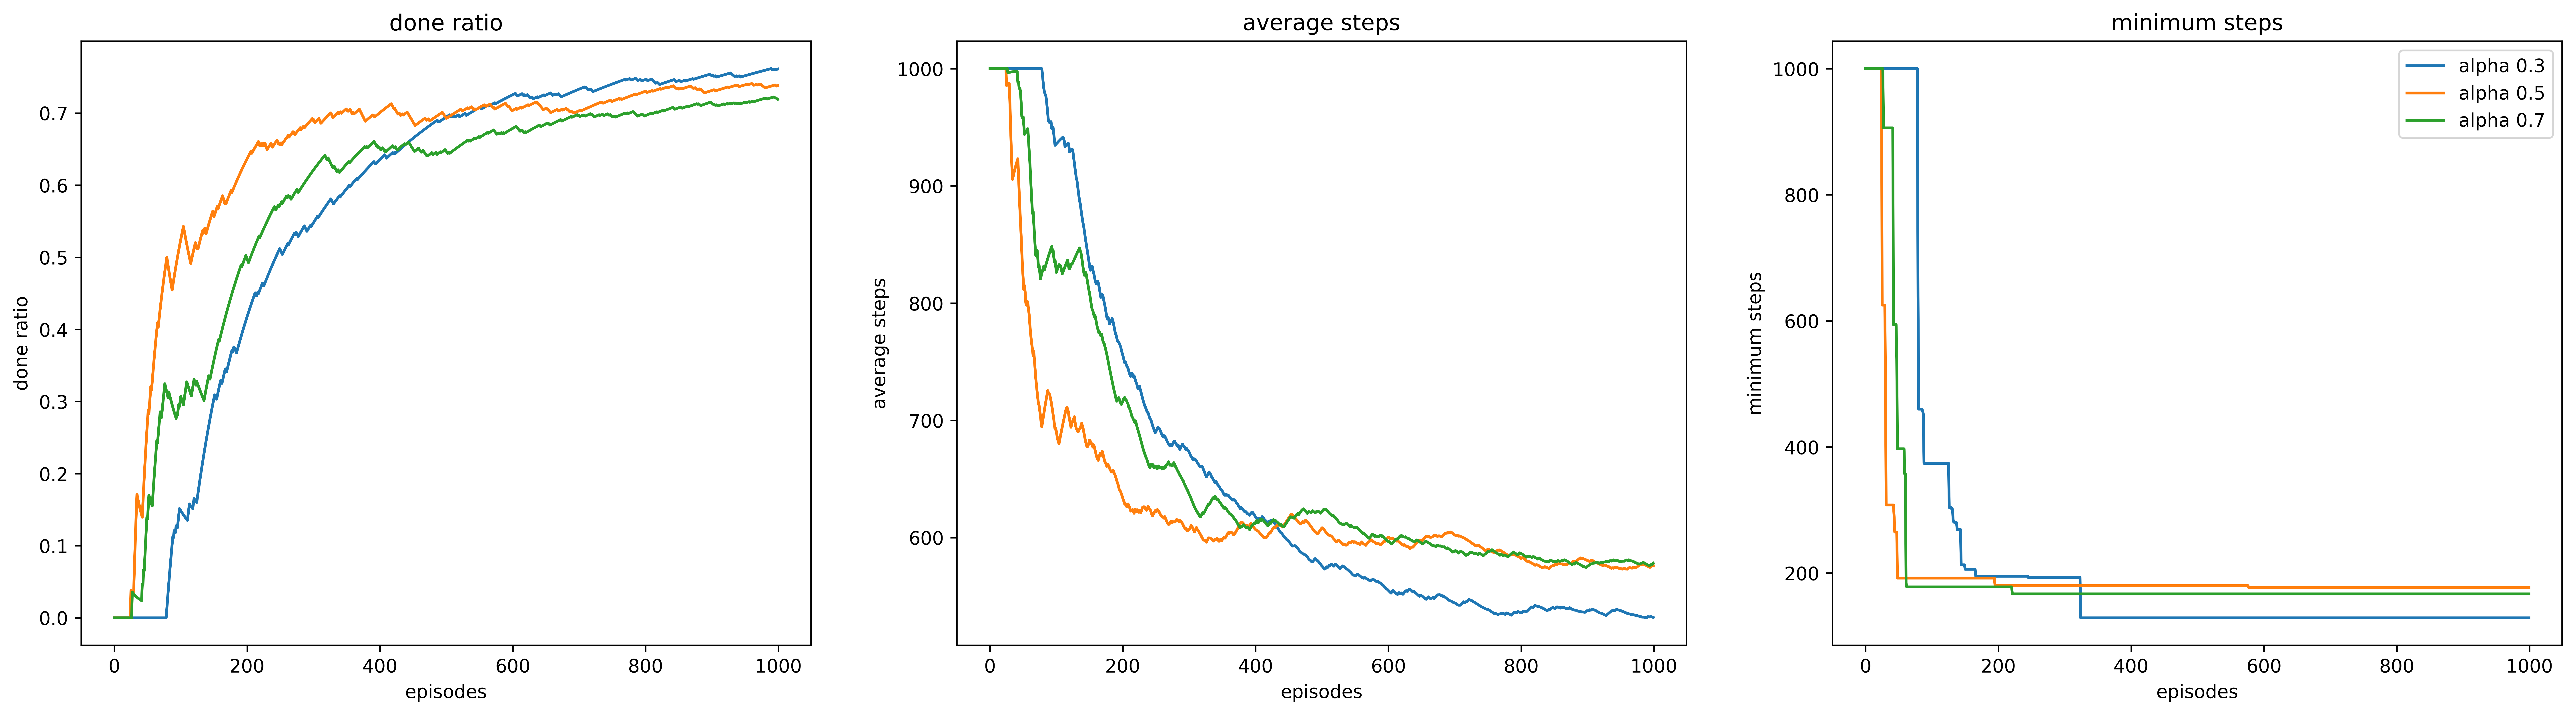

In [274]:
plotLearnCurve("learn curve in diff alpha", 
               alphalabels,
               alphadatas
              )

In [264]:
gammadatas = list()
gammalabels = list()

alpha = 0.5
r_choose = 0.01

gamma = 0.5

print("\ngamma = {}".format(gamma))
gammalabels.append("gamma {}".format(gamma))
tmp = RL(customRewardWithDone)
gammadatas.append(tmp[1])

gamma = 0.7

print("\ngamma = {}".format(gamma))
gammalabels.append("gamma {}".format(gamma))
tmp = RL(customRewardWithDone)
gammadatas.append(tmp[1])

gamma = 0.9

print("\ngamma = {}".format(gamma))
gammalabels.append("gamma {}".format(gamma))
tmp = RL(customRewardWithDone)
gammadatas.append(tmp[1])

print("\n\nfinish!~")


gamma = 0.5
start 0 episode !
start 100 episode !
start 200 episode !
start 300 episode !
start 400 episode !
start 500 episode !
start 600 episode !
start 700 episode !
start 800 episode !
start 900 episode !
finish 1000 episode!

gamma = 0.7
start 0 episode !
start 100 episode !
start 200 episode !
start 300 episode !
start 400 episode !
start 500 episode !
start 600 episode !
start 700 episode !
start 800 episode !
start 900 episode !
finish 1000 episode!

gamma = 0.9
start 0 episode !
start 100 episode !
start 200 episode !
start 300 episode !
start 400 episode !
start 500 episode !
start 600 episode !
start 700 episode !
start 800 episode !
start 900 episode !
finish 1000 episode!


finish!~


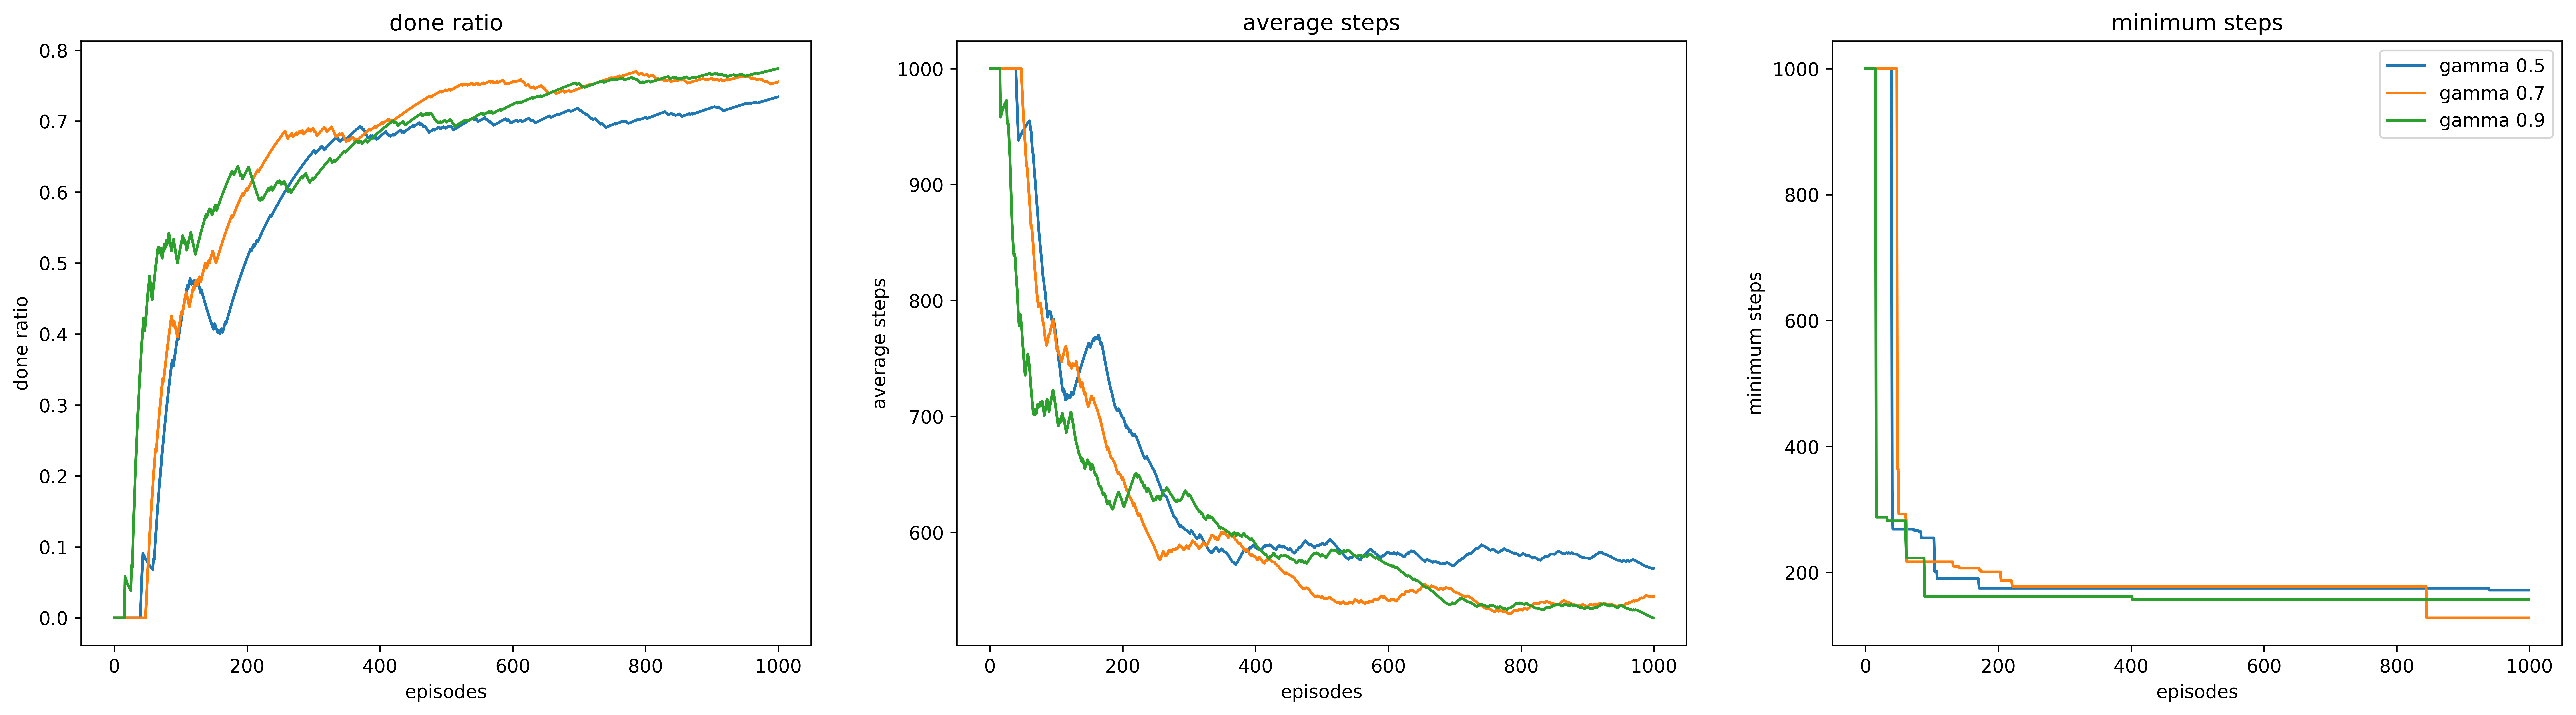

In [275]:
plotLearnCurve("learn curve in diff gamma", 
               gammalabels,
               gammadatas
              )

In [268]:
r_choosedatas = list()
r_chooselabels = list()

alpha = 0.5
gamma = 0.7

r_choose = 0.01

print("\nr_choose = {}".format(r_choose))
r_chooselabels.append("epsilon {}".format(r_choose))
tmp = RL(customRewardWithDone)
r_choosedatas.append(tmp[1])

r_choose = 0.1

print("\nr_choose = {}".format(r_choose))
r_chooselabels.append("epsilon {}".format(r_choose))
tmp = RL(customRewardWithDone)
r_choosedatas.append(tmp[1])

r_choose = 0.3

print("\nr_choose = {}".format(r_choose))
r_chooselabels.append("epsilon {}".format(r_choose))
tmp = RL(customRewardWithDone)
r_choosedatas.append(tmp[1])

print("\n\nfinish!~")


r_choose = 0.01
start 0 episode !
start 100 episode !
start 200 episode !
start 300 episode !
start 400 episode !
start 500 episode !
start 600 episode !
start 700 episode !
start 800 episode !
start 900 episode !
finish 1000 episode!

r_choose = 0.1
start 0 episode !
start 100 episode !
start 200 episode !
start 300 episode !
start 400 episode !
start 500 episode !
start 600 episode !
start 700 episode !
start 800 episode !
start 900 episode !
finish 1000 episode!

r_choose = 0.3
start 0 episode !
start 100 episode !
start 200 episode !
start 300 episode !
start 400 episode !
start 500 episode !
start 600 episode !
start 700 episode !
start 800 episode !
start 900 episode !
finish 1000 episode!


finish!~


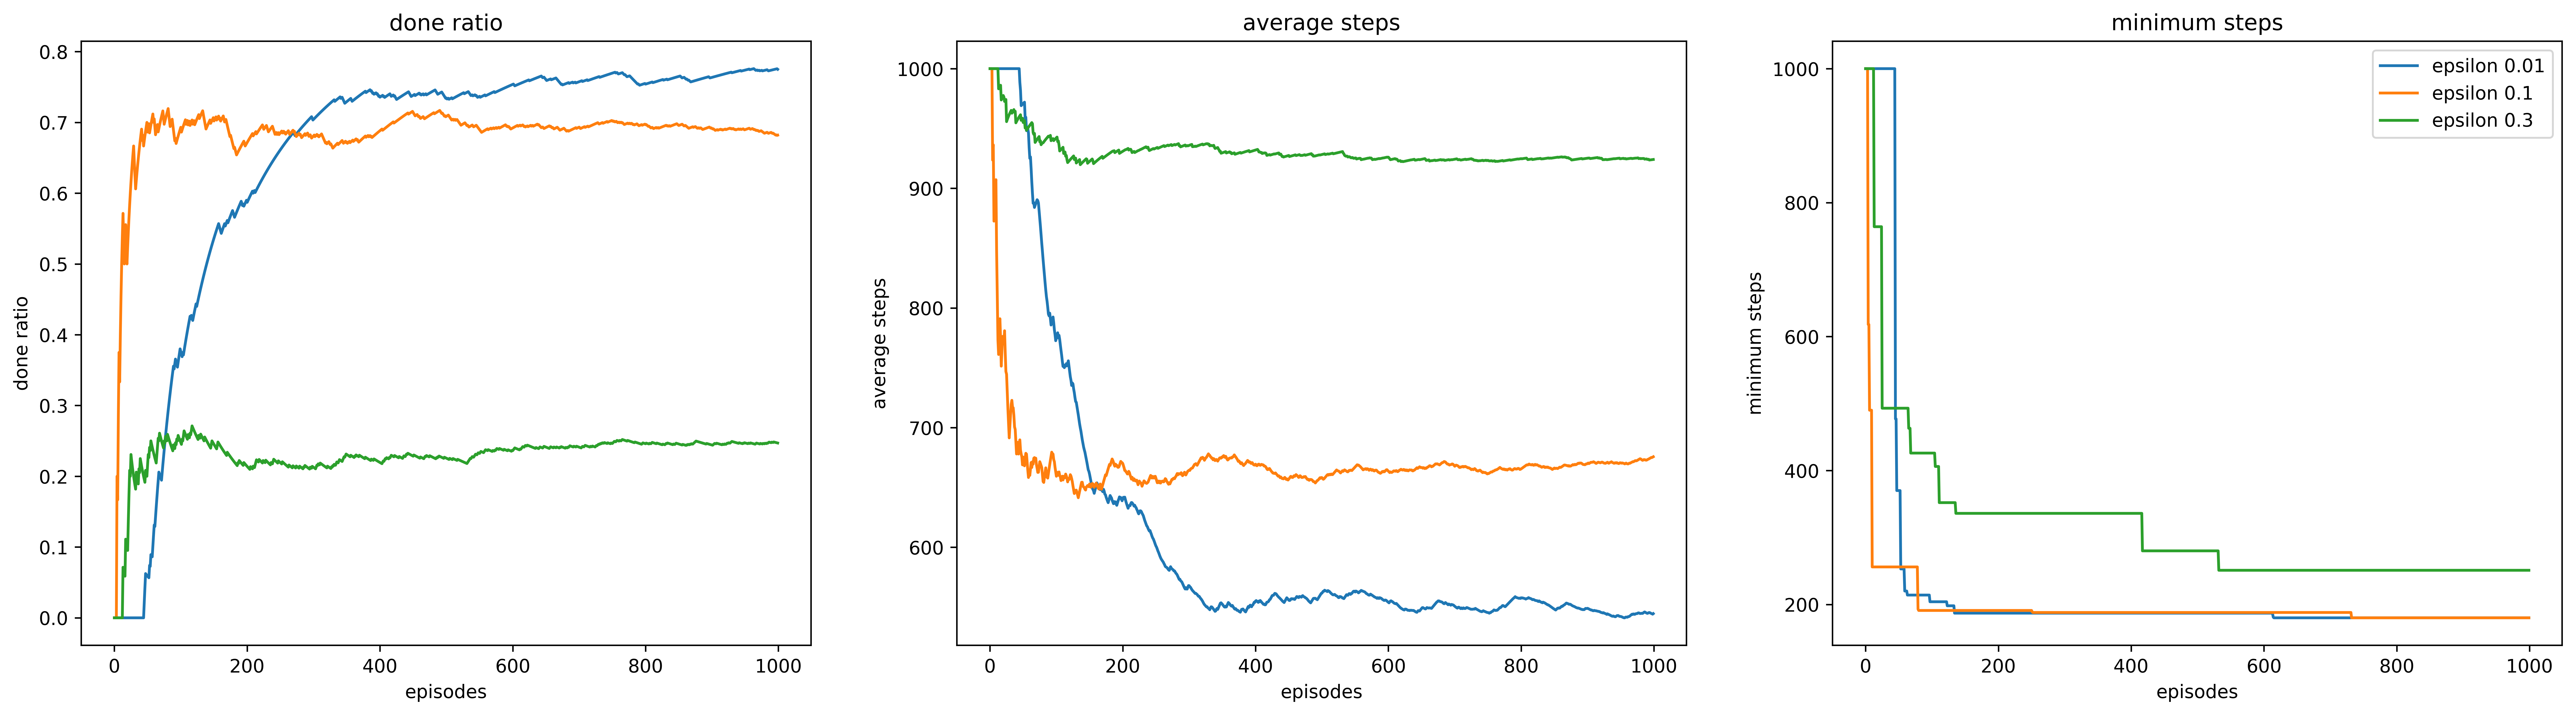

In [276]:
plotLearnCurve("learn curve in diff gamma", 
               r_chooselabels,
               r_choosedatas
              )